In [2]:
from base import *
from utils import pauli_sum, entropy
import plot_utils
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM, COBYLA
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter 
from qiskit.circuit.library import TwoLocal
import numpy as np

In [3]:
from algorithms import Vqe 

## J=2

In [4]:
# constants
eps = 1
z_coeff = 0.5 * eps



In [5]:

def H(V,W):
    return np.array([[-2*eps, 0, np.sqrt(6)*V, 0, 0],
                  [0, -eps+3*W, 0, 3*V, 0],
                  [np.sqrt(6)*V, 4*W, 0, 0, np.sqrt(6)*V],
                  [0, 3*V, 0, eps+3*W, 0],
                  [0, 0, np.sqrt(6)*V, 0, 2*eps]])

# H(0)

# def my_H(v):
    
#     x_coeff = -v/2
#     y_coeff = v/2
#     return pauli_sum([('ZIII', z_coeff), ('IZII', z_coeff), ('IIZI', z_coeff), ('IIIZ', z_coeff), # all 1 qubit combinations
#                       ('XXII', x_coeff), ('XIXI', x_coeff), ('XIIX', x_coeff), ('IXXI', x_coeff), ('IXIX', x_coeff), ('IIXX', x_coeff), # all 2 qubit combinations
#                       ('YYII', y_coeff), ('YIYI', y_coeff), ('YIIY', y_coeff), ('IYYI', y_coeff), ('IYIY', y_coeff), ('IIYY', y_coeff)])

# my_H(0)

In [67]:
vs = np.arange(0, 1, 0.02)
ws = np.arange(0, 2, 0.02)
# vs, ws = np.meshgrid(vs, ws) 
print(vs.shape, ws.shape)
eigs = np.zeros((5, len(vs), len(ws)))

for i, v in enumerate(vs):
    for j, w in enumerate(ws):
        eigvals, eigvecs = np.linalg.eig(H(v, w))
        eigs[:, i, j] = sorted(eigvals)

(50,) (100,)


In [ ]:
vs = np.arange(0, 2, 0.02)
ws = np.arange(0, 2, 0.02)
eigs = np.zeros((5, len(vs)))

# let v=w
v=1
for i, w in enumerate(ws):
    eigvals, eigvecs = np.linalg.eig(H(v,v))
    eigs[:,i] = sorted(eigvals)

plot_2D(vs, eigs, plot_count=5, title=r"Numerical Eigenvalues for $J=2$ with v=w", x_title=r'$v$', 
        label = [rf'$E_{i}$' for i in range(5)], y_title='Energies for v=1')

In [7]:
# plot_2D(vs, eigs, plot_count=5, title=r"Numerical Eigenvalues for $J=2$ with v=w", x_title=r'$v$', 
#         label = [rf'$E_{i}$' for i in range(5)], y_title='Energies for v=w', filename='lipkin-eigs-4-w.pdf')

Text(9.444444444444454, 0.5, 'vs')

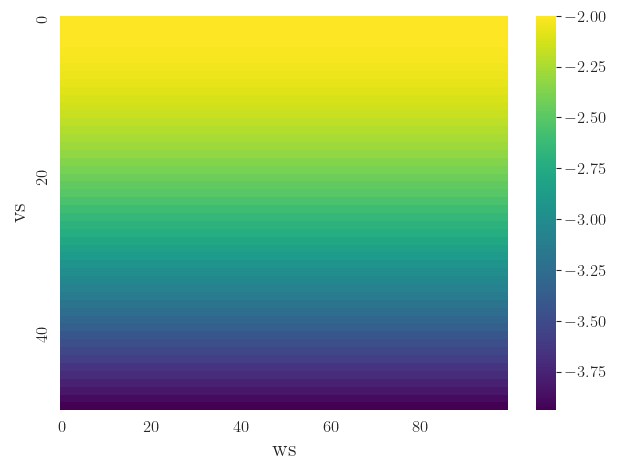

In [73]:
# ax.plot_surface(vs, ws, eigs[0, :, :])  # Plotting the first eigenvalue (you can change the index to plot different eigenvalues)

eigs_reshaped = eigs[0, :, :]  # Choose the first eigenvalue (you can change the index to plot different eigenvalues)

# Create a heatmap using Seaborn
sns.heatmap(eigs[0], cmap='viridis', xticklabels=20, yticklabels=20)

# Set labels and title
plt.xlabel('ws')
plt.ylabel('vs')
# plt.title('Eigenvalues Heatmap')

As we can see, every eigenvalue has a degenerate value. However $E_3$ and $E_{14}$ are energy eigenvalues that we do not get from the 5x5 matrix. 

In [100]:
def my_H(v, w):
    
    x_coeff = -v/2 + w
    y_coeff = v/2 + w
    return PauliSumOp.from_list([('IIII', 2*w), 
                                ('ZIII', z_coeff), ('IZII', z_coeff), ('IIZI', z_coeff), ('IIIZ', z_coeff), # all 1 qubit combinations
                                ('XXII', x_coeff), ('XIXI', x_coeff), ('XIIX', x_coeff), ('IXXI', x_coeff), ('IXIX', x_coeff), ('IIXX', x_coeff), # all 2 qubit combinations
                                ('YYII', y_coeff), ('YIYI', y_coeff), ('YIIY', y_coeff), ('IYYI', y_coeff), ('IYIY', y_coeff), ('IIYY', y_coeff)])

# my_H(0)

In [101]:
def prep_vqe(n,reps):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    cobyla = COBYLA(maxiter = 500)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()
    ansatz = TwoLocal(n, ['rx', 'ry'], 'cx', reps=reps, entanglement='full')
    vqe = VQE(ansatz = ansatz,
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2 * n * (reps+1)), 
              estimator=estimator)

    return vqe

In [102]:
n_qubits=4

vs = np.arange(0,2,0.02) # rmb to divide when used
n_points = len(vs)
vqe = prep_vqe(n_qubits, reps=2)
energies = np.zeros((len(vs), len(vs))) # containers for the energies

for i, v in enumerate(vs):
    for j, w in enumerate(ws):
        # print(ham)
        result = vqe.compute_minimum_eigenvalue(my_H(v,w))
        energies[i, j] = result.eigenvalue.real
        print(f'v = {v}, energy = {result.eigenvalue.real}')




v = 0.0, energy = -1.9999998483207149
v = 0.0, energy = -1.9599998636148315
v = 0.0, energy = -1.9199992035635194
v = 0.0, energy = -1.879999730151253
v = 0.0, energy = -1.8399999431777274
v = 0.0, energy = -1.7999998048479424
v = 0.0, energy = -1.7599993704930463
v = 0.0, energy = -1.7199998626690358
v = 0.0, energy = -1.679999362367875
v = 0.0, energy = -1.6399985266327464
v = 0.0, energy = -1.5999995262993454
v = 0.0, energy = -1.5599996269180514
v = 0.0, energy = -1.519999755530843
v = 0.0, energy = -1.4799996272771876
v = 0.0, energy = -1.4399992688704335
v = 0.0, energy = -1.3999997295505135
v = 0.0, energy = -1.3599991919052596
v = 0.0, energy = -1.319999093704898
v = 0.0, energy = -1.2799996040451245
v = 0.0, energy = -1.2399983251210307
v = 0.0, energy = -1.199998785247853
v = 0.0, energy = -1.1599927356692292
v = 0.0, energy = -1.11999555956831
v = 0.0, energy = -1.079974941770795
v = 0.0, energy = -1.0399973307658243
v = 0.0, energy = -0.9999943153969884
v = 0.0, energy = -1